In [98]:
import psycopg2
import pandas as pd
import sh
from IPython.display import display, HTML, Javascript

# Note: assumes that you have a "parcels"/"nfirs"/"firecares-vm" service listed in your ~/.pg_service.conf, "firecares-vm"
# should point at your dev FireCARES vm's database (which requires the FireDepartment.owned_tracts_geom property for
# correct intersection), "parcels" and "nfirs" connections point to the production database instances

parcels = psycopg2.connect('service=parcels')
fc = psycopg2.connect('service=firecares-vm')
fc_dev = psycopg2.connect('service=firecares-dev')
nfirs = psycopg2.connect('service=nfirs')

def heading(text, tag='h3'):
    display(HTML('<{tag}>{text}</{tag}>'.format(tag=tag, text=text)))
    
# Requires https://github.com/catherinedevlin/ipython-sql
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [ ]:
# Create an intermediary table for backing-up only the department information we care about for local restoration
# into the parcels database
with fc.cursor() as c:
    c.execute('SELECT id, owned_tracts_geom INTO firedepartment_owned_geom FROM firestation_firedepartment where owned_tracts_geom IS NOT null;')
    fc.commit()
sh.pg_dump('service=firecares-vm', '-O', '-t', 'firedepartment_owned_geom', _out='/tmp/firedepartment_owned_geom.sql')

# Load FDs
sh.psql('service=parcels', _in=file('/tmp/firedepartment_owned_geom.sql', 'r'))

In [ ]:
# Might be overkill, but filtering down to a much smaller table size to scan when performing intersections
# this will definitely take some time to complete
with parcels.cursor() as c:
    c.execute("""SELECT ogc_fid, wkb_geometry, parcel_id, state, zip, land_use, story_nbr INTO parcel_stories
    FROM parcels p INNER JOIN "LUSE_swg" lu
    on p.land_use = lu."Code"
    WHERE lu.include_in_floor_dist""")
    c.execute("""CREATE INDEX ON parcel_stories USING gist (wkb_geometry);""")
    c.execute("""CREATE INDEX on parcel_stories (state);""")
    c.execute("""CREATE INDEX on parcel_stories (land_use);""")
    parcels.commit()

In [80]:
df = pd.read_sql_query("""SELECT count(1) FROM parcels p INNER JOIN "LUSE_swg" u ON u."Code" = p.land_use AND p.state = 'DC';""", parcels)
print 'Total parcels in DC w/ land_use hit: {}'.format(df['count'][0])

df = pd.read_sql_query("""SELECT count(1) FROM parcels p WHERE p.land_use is null and p.state = 'DC';""", parcels)
print 'Total parcels in DC w/ no land_use: {}'.format(df['count'][0])

Total parcels in DC w/ land_use hit: 133014
Total parcels in DC w/ no land_use: 3538


In [59]:
# Get counts over DC for medium/high structures
df = pd.read_sql_query("""select count(1), p.story_nbr, p.land_use, lu.risk_category, lu."Description", lu.residential
from parcels p
    join "LUSE_swg" lu
    on lu."Code" = p.land_use
where state = 'DC' and lu.include_in_floor_dist
group by p.story_nbr, p.land_use, lu.risk_category, lu."Description", lu.residential
order by count desc, p.story_nbr, p.land_use""", parcels)

df.style.highlight_null(null_color='red')

In [61]:
# Get counts over Missouri for medium/high structures

df = pd.read_sql_query("""select count(1), p.story_nbr, p.land_use, lu.risk_category, lu."Description", lu.residential
from parcels p
    join "LUSE_swg" lu
    on lu."Code" = p.land_use
where state = 'MO' and lu.include_in_floor_dist
group by p.story_nbr, p.land_use, lu.risk_category, lu."Description", lu.residential
order by count desc, p.story_nbr, p.land_use""", parcels)

df.style.highlight_null(null_color='red')

In [2]:
# Pull CSV for land use codes to include in DIST score

df = pd.read_csv("/Users/joe/Downloads/risk_categories.csv")
df2 = df[df['floor_dist'].notnull()].sort_values(by='Code')
df2

,Code,Description,risk_category,residential,floor_dist
251,103,APARTMENT/HOTEL,Medium,Yes,yes
252,106,APARTMENT,Medium,Yes,yes
253,111,COOPERATIVE,Medium,Yes,yes
254,112,CONDOMINIUM,Medium,Yes,yes
255,113,CONDOMINIUM PROJECT,Medium,Yes,yes
232,116,MID RISE CONDO,High,Yes,yes
233,117,HIGH RISE CONDO,High,Yes,yes
257,118,FRAT/SORORITY HOUSE,High,Yes,yes
258,119,RESIDENCE HALL/DORMITORIES,Medium,Yes,yes
259,127,HOTEL,Medium,Yes,yes


In [4]:
%sql postgresql:///?service=parcels alter table "LUSE_swg" add column include_in_floor_dist boolean not null default false;

Done.


[]

In [ ]:
# Import included land use types in the DIST calculations

included_codes = map(str, list(df2['Code'].values))

for code in included_codes:
    %sql update "LUSE_swg" set include_in_floor_dist = true where "Code" = :code

In [ ]:
%%sql

select * from
parcels p
join firedepartment_owned_geom og
on ST_Intersects(p.wkb_geometry, og.owned_tracts_geom)
where og.id = 87256
group by 

In [ ]:
# Get most egregious offenders for null story counts by land usage category
df = pd.read_sql_query("""select count(1), p.story_nbr, p.land_use, lu.risk_category, lu."Description", lu.residential
from parcels p
    join "LUSE_swg" lu
    on lu."Code" = p.land_use
where lu.include_in_floor_dist and p.story_nbr is null
group by p.story_nbr, p.land_use, lu.risk_category, lu."Description", lu.residential
order by count desc, p.story_nbr, p.land_use""", parcels)

df.style.highlight_null(null_color='red')

In [4]:
from scipy.stats import lognorm
from matplotlib import pyplot as plt

In [ ]:
%%sql postgresql:///?service=parcels

select count(1), story_nbr
from parcel_stories p
    join firedepartment_owned_geom g on ST_Intersects(p.wkb_geometry, g.owned_tracts_geom)
where p.state = 'CA'
group by story_nbr
limit 1000;

In [ ]:
# Get counts over LAFD for medium/high structures

df = pd.read_sql_query("""select count(1), p.story_nbr, p.land_use, lu.risk_category, lu."Description", lu.residential
from parcels p
    join "LUSE_swg" lu on lu."Code" = p.land_use
    join firedepartment_owned_geom g on ST_Intersects(g.owned_tracts_geom, p.wkb_geometry)
where lu.include_in_floor_dist and lu.risk_category = 'Medium'
group by p.story_nbr, p.land_use, lu.risk_category, lu."Description", lu.residential
order by count desc, p.story_nbr, p.land_use""", parcels)

df.style.highlight_null(null_color='red')

In [24]:
# Get counts for structures types over ALL states

df = pd.read_sql_query("""select count(1), p.story_nbr, lu."Code", lu."Description", p.state
from parcel_stories p
join "LUSE_swg" lu
    on lu."Code" = p.land_use
where lu.include_in_floor_dist
group by p.story_nbr, lu."Code", lu."Description", p.state
having count(1) > 10
order by p.state, count desc, story_nbr;""", parcels)

df

,count,story_nbr,Code,Description,state
0,2742,NaN,106,APARTMENT,AK
1,2738,NaN,112,CONDOMINIUM,AK
2,1435,NaN,133,MULTI FAMILY DWELLING,AK
3,852,1.00,133,MULTI FAMILY DWELLING,AK
4,804,NaN,244,OFFICE BUILDING,AK
5,417,1.50,133,MULTI FAMILY DWELLING,AK
6,401,2.00,133,MULTI FAMILY DWELLING,AK
7,345,2.00,112,CONDOMINIUM,AK
8,342,2.00,165,TRIPLEX,AK
9,240,1.00,165,TRIPLEX,AK


In [ ]:
%%sql postgresql:///?service=parcels

select count(1), p.story_nbr, lu."Code", lu."Description", p.state
from parcel_stories p
join "LUSE_swg" lu
    on lu."Code" = p.land_use
join firedepartment_owned_geom g
    on ST_Intersects(g.owned_tracts_geom, p.wkb_geometry)
where g.id = 87256 and lu.include_in_floor_dist
group by p.story_nbr, lu."Code", lu."Description", p.state
order by p.state, count desc, story_nbr;

In [ ]:
# Move parcel_stories over to NFIRS db (takes quite awhile)
%%bash

pg_dump service=parcels -O -t parcel_stories > /tmp/parcel_stories.sql
psql service=nfrs < /tmp/parcel_stories.sql

In [6]:
with nfirs.cursor() as c:
    c.execute("""CREATE INDEX ON parcel_stories USING gist (wkb_geometry);""")
    c.execute("""CREATE INDEX on parcel_stories (state);""")
    c.execute("""CREATE INDEX on parcel_stories (land_use);""")

In [ ]:
%%bash

pg_dump service=parcels -t firedepartment_owned_geom -O | psql service=nfirs
pg_dump service=parcels -t \"LUSE_swg\" -O | psql service=nfirs

In [ ]:
%%sql postgresql:///?service=nfirs

select count(1), p.story_nbr, p.land_use, lu.risk_category, lu."Description", lu.residential
from parcel_stories p
    join "LUSE_swg" lu on lu."Code" = p.land_use
    join firedepartment_owned_geom g on ST_Intersects(g.owned_tracts_geom, p.wkb_geometry)
where lu.include_in_floor_dist and lu.risk_category = 'Medium'
group by p.story_nbr, p.land_use, lu.risk_category, lu."Description", lu.residential
order by count desc, p.story_nbr, p.land_use;

### Curve fitting for story counts

##### Pull story counts for LAFD over similar departments (for medium hazard level)

In [103]:
%%sql postgresql:///?service=nfirs

select count(1), p.story_nbr
from parcel_stories p
    join "LUSE_swg" lu on lu."Code" = p.land_use,
    (select * from firedepartment_owned_geom) as g
where lu.include_in_floor_dist and lu.risk_category = 'Medium'
and ST_Intersects(g.owned_tracts_geom, p.wkb_geometry)
group by p.story_nbr
order by count desc, p.story_nbr;

137 rows affected.


count,story_nbr
508284,None
329871,2.0
257268,1.0
117398,3.0
27059,4.0
15818,5.0
11889,6.0
7280,1.5
4713,2.5
2636,2.75


In [1]:
res = _

##### Lognorm curve fitting

In [ ]:
from scipy.stats import lognorm
import numpy as np
import matplotlib.pyplot as plt

# Filter out `None` story counts
a = map(lambda x: (x[0], x[1] if x[1] else 0), filter(lambda x: x[1] is not None and x[1] <= 108, res))
weights = np.array(map(lambda x: x[0], a))
values = np.array(map(lambda x: x[1], a))

def expand(values, weights):
    ret = []
    for v in zip(values, weights):
        ret = ret + [v[0]] * v[1]
    return ret

#expanded = expand(values, weights)
print weights
print values
print 'NORMALIZED WEIGHT sum'  # Should be 1
print sum(weights / float(sum(weights)))

samples = np.random.choice(values, size=1000, p=weights / float(sum(weights)))
print 'SAMPLES'
print samples[:100]
x = np.linspace(0, max(samples), 1000)
samp = lognorm.fit(samples)
print 'CURVE'
print samp
rvs_samples = lognorm.rvs(*samp, size=1000)
print 'RVS_SAMPLES'
print rvs_samples[:100]
pdf_fitted = lognorm.pdf(x, samp[0], loc=samp[1], scale=samp[2])

PDF_FITTED
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          2.45488682  1.09207787  0.70625941
  0.5225209   0.41473669  0.34378317  0.29350263  0.25599481  0.226935
  0.20375517  0.18483346  0.16909483  0.15579834  0.14441664  0.13456409
  0.12595217  0.11836067  0.1116186   0.10559117  0.10017065  0.09526997
  0.09081791  0.08675573  0.08303449  0.07961311  0.07645685  0.07353615
  0.07082567  0.06830358  0.06595097  0.06375137  0.06169039  0.05975538
  0.05793517  0.05621989  0.05460077  0.05306996  0.05162048  0.05024603
  0.04894098  0.04770022  0.04651913  0.04539355  0.04431966  0.043294
  0.04231341  0.04137502  0.04047615  0.03961439  0.03878749  0.0379934
  0.03723021  0.03649617  0.0

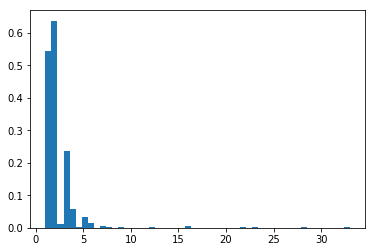

In [110]:
print 'PDF_FITTED'
print pdf_fitted[:100]

plt.hist(samples, 50, normed=1)
#plt.gca().set_yscale("log")
#plt.plot(x, pdf_fitted, 'r-')
plt.show()

In [94]:
# utils yanked from DIST calculation

class DrawType(object):
    """
    Implements a base DrawType object.
    """
    def draw(self):
        raise NotImplementedError
        

class LogNormalDraw(DrawType):
    """
    Implements a log normal draw.
    >>> import numpy as np
    >>> np.random.seed(1234)
    >>> ud = LogNormalDraw(0.3381962232249362, -1.0844073333047395, 3.1682731892016429)
    >>> ud.draw()
    2.631505249260421
    """
    def __init__(self, shape, location, scale, multiplier=1):
        self.shape = shape
        self.location = location
        self.scale = scale
        self.multiplier = multiplier

    def draw(self):
        return lognorm.rvs(self.shape, self.location, self.scale) * self.multiplier

##### Validate curve by drawing a large set of points

(4.6229973046852173, 0.9999999999999829, 3.2652912388296444e-05)
3.58724348512
22590.3222823
1.0


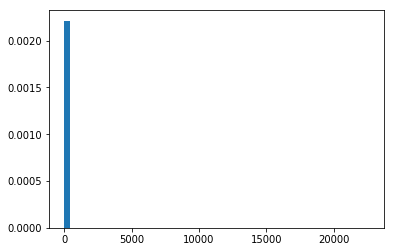

In [104]:
print samp
lnd = LogNormalDraw(*samp)

samples = []
for i in range(10000):
    samples.append(lnd.draw())
    
npa = np.array(samples)
print npa.mean()
print npa.max()
print npa.min()

plt.hist(samples, 50, normed=1)
plt.show()

#### Collect over all similar departments

In [ ]:
%%bash

pg_dump service=parcels -t \"LUSE_swg\" -O | psql service=nfirs

In [22]:
%%sql postgresql:///?service=firecares-dev
    
select count(1) from firestation_firedepartment where owned_tracts_geom is not null;

1 rows affected.


count
17491


In [23]:
%%bash

pg_dump service=firecares-dev -t firestation_firedepartment -O > /tmp/firestation_firedepartment.sql
sed -i -e 's/firestation_firedepartment/firestation_firedepartment_dev/g' /tmp/firestation_firedepartment.sql

In [ ]:
%%sql postgresql:///?service=nfirs

In [6]:
with fc_dev.cursor() as c:
    c.execute('select 1;')
    res = c.fetchall()
res

[(1,)]

In [4]:
similar_to_lafd = [87256, 87255,
 77379,
 84578,
 88539,
 91907,
 91934,
 91105,
 94250,
 77867,
 89649,
 79277,
 73343,
 81147,
 81472]

In [5]:
with fc_dev.cursor() as c:
    c.execute('select owned_tracts_geom from firestation_firedepartment where id in %(similar)s', {'similar': tuple(similar_to_lafd)})
    geoms = c.fetchall()

In [8]:
with nfirs.cursor() as c:
    for g in geoms:
        c.execute('insert into firedepartment_owned_geom (owned_tracts_geom) values (%(geom)s::geometry)', {'geom': g[0]})
nfirs.commit()

0106000020
0106000020
0106000020
0106000020
0106000020
0106000020
0106000020
0106000020
0106000020
0106000020
0106000020
0106000020
0106000020
0106000020
0106000020
